ADQL search for the bright stars around the open cluster M67

In [1]:
#Importing all the important libraries
from astroquery.gaia import Gaia


Gaia.login(user='schatu01', password='221Baker@')
from astropy.table import Table, join
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import requests


INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]


The objective here is to retrieve all stars within 1 degree of Messier 67's center (RA = 132.825 deg, Dec = 11.8 deg) that are brighter than G = 14 from Gaia DR3, and crossmatch these stars with the 2MASS catalog.

In [2]:
querry = '''SELECT
  gaia.source_id,
  gaia.ra,
  gaia.dec,
  gaia.phot_g_mean_mag,
  gaia.parallax,
  gaia.pmra,
  gaia.pmdec,
  tmass.*
FROM
  gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass
  ON xjoin.original_psc_source_id = tmass.designation
WHERE
  CONTAINS(
    POINT('ICRS', gaia.ra, gaia.dec),
    CIRCLE('ICRS', 132.825, 11.8, 1)
  ) = 1
  AND gaia.phot_g_mean_mag < 14'''

To calculate the number of stars :

In [3]:
# Load the data into a DataFrame
data = pd.read_csv('/Users/shauryachaturvedi/Desktop/ASTRO_ASS/ASTRCOMP_ASS_3/data/M67_Bright_Stars.csv')

# Get the number of rows in the DataFrame
num_stars = len(data)
print(f"Number of stars returned from the initial query: {num_stars}")


Number of stars returned from the initial query: 1018


In [4]:
# Check for duplicate source IDs
unique_stars = data['source_id'].nunique()

print(f"Number of unique stars based on source_id: {unique_stars}")


Number of unique stars based on source_id: 1018


 Identify Stars with Bad Photometry

In [5]:
# Filter stars with bad 2MASS photometry
bad_photometry = data[data['ph_qual'] != 'AAA']

# Get the number of stars with bad photometry
num_bad_photometry = len(bad_photometry)

print(f"Number of stars with bad 2MASS photometry (ph_qual != 'AAA'): {num_bad_photometry}")


Number of stars with bad 2MASS photometry (ph_qual != 'AAA'): 21


In [6]:
# Filter stars with negative or zero parallax
non_positive_parallax = data[data['parallax'] <= 0]

# Get the number of stars with non-positive parallax
num_non_positive_parallax = len(non_positive_parallax)

print(f"Number of stars with non-positive parallaxes (parallax ≤ 0): {num_non_positive_parallax}")


Number of stars with non-positive parallaxes (parallax ≤ 0): 2


In [7]:
# Filter stars with good 2MASS photometry
data_good_photometry = data[data['ph_qual'] == 'AAA']

# Number of stars after first cut
num_after_first_cut = len(data_good_photometry)
print(f"Number of stars after removing bad 2MASS photometry: {num_after_first_cut}")
# From the data with good photometry, filter stars with positive parallax
data_after_cuts = data_good_photometry[data_good_photometry['parallax'] > 0]

# Number of stars after both cuts
num_after_both_cuts = len(data_after_cuts)
print(f"Number of stars after applying both quality cuts: {num_after_both_cuts}")


Number of stars after removing bad 2MASS photometry: 997
Number of stars after applying both quality cuts: 988


Summary of the filtering process

In [8]:
# Initial number of stars
initial_num_stars = len(data)
print(f"Initial number of stars: {initial_num_stars}")

# Number of stars with bad photometry
num_bad_photometry = len(data[data['ph_qual'] != 'AAA'])
print(f"Number of stars with bad 2MASS photometry: {num_bad_photometry}")

# Number of stars with non-positive parallax
num_non_positive_parallax = len(data[data['parallax'] <= 0])
print(f"Number of stars with non-positive parallaxes: {num_non_positive_parallax}")

# Total number of stars removed (accounting for overlap)
num_stars_removed = initial_num_stars - num_after_both_cuts
print(f"Total number of stars removed: {num_stars_removed}")


Initial number of stars: 1018
Number of stars with bad 2MASS photometry: 21
Number of stars with non-positive parallaxes: 2
Total number of stars removed: 30


In [9]:
# Number of stars with null ph_qual
num_null_ph_qual = data['ph_qual'].isnull().sum()
print(f"Number of stars with null ph_qual: {num_null_ph_qual}")

# Number of stars with null parallax
num_null_parallax = data['parallax'].isnull().sum()
print(f"Number of stars with null parallax: {num_null_parallax}")


Number of stars with null ph_qual: 0
Number of stars with null parallax: 7


In [10]:
# Remove stars with null ph_qual or parallax
data_clean = data.dropna(subset=['ph_qual', 'parallax'])

# Apply quality cuts to the cleaned data
data_good_photometry = data_clean[data_clean['ph_qual'] == 'AAA']
data_after_cuts = data_good_photometry[data_good_photometry['parallax'] > 0]

# Update the counts
num_after_both_cuts = len(data_after_cuts)
print(f"Number of stars after applying quality cuts and removing nulls: {num_after_both_cuts}")


Number of stars after applying quality cuts and removing nulls: 988


In [ ]:
# Create a figure with specified resolution and size
plt.figure(figsize=(14, 6), dpi=200)

# Adjust font sizes for readability
plt.rcParams.update({'font.size': 12})


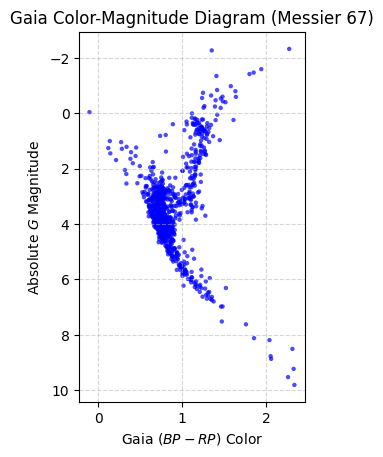

In [11]:
# Panel (a): Gaia CMD
plt.subplot(1, 2, 1)

# Calculate distances in parsecs
parallax = data_after_cuts['parallax'].values  # in milliarcseconds
distance_pc = 1000 / parallax

# Calculate Absolute G Magnitude
G_abs = data_after_cuts['phot_g_mean_mag'] - 5 * np.log10(distance_pc / 10)

# Gaia BP - RP color
BP_RP = data_after_cuts['bp_rp']

# Plotting
plt.scatter(BP_RP, G_abs, s=10, color='blue', alpha=0.7, edgecolors='none')

# Invert y-axis (brighter stars at the top)
plt.gca().invert_yaxis()

# Labels and Title
plt.xlabel(r'Gaia $(BP - RP)$ Color')
plt.ylabel(r'Absolute $G$ Magnitude')
plt.title('Gaia Color-Magnitude Diagram (Messier 67)')

# Grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)


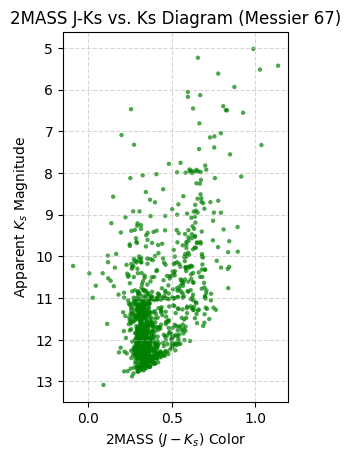

In [12]:
# Panel (b): 2MASS J-Ks vs. Apparent Ks Magnitude
plt.subplot(1, 2, 2)

# Extract J and Ks magnitudes
J_mag = data_after_cuts['j_m']
Ks_mag = data_after_cuts['ks_m']

# Calculate J - Ks Color
J_Ks = J_mag - Ks_mag

# Plotting
plt.scatter(J_Ks, Ks_mag, s=10, color='green', alpha=0.7, edgecolors='none')

# Invert y-axis (brighter stars at the top)
plt.gca().invert_yaxis()

# Labels and Title
plt.xlabel(r'2MASS $(J - K_s)$ Color')
plt.ylabel(r'Apparent $K_s$ Magnitude')
plt.title('2MASS J-Ks vs. Ks Diagram (Messier 67)')

# Grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)


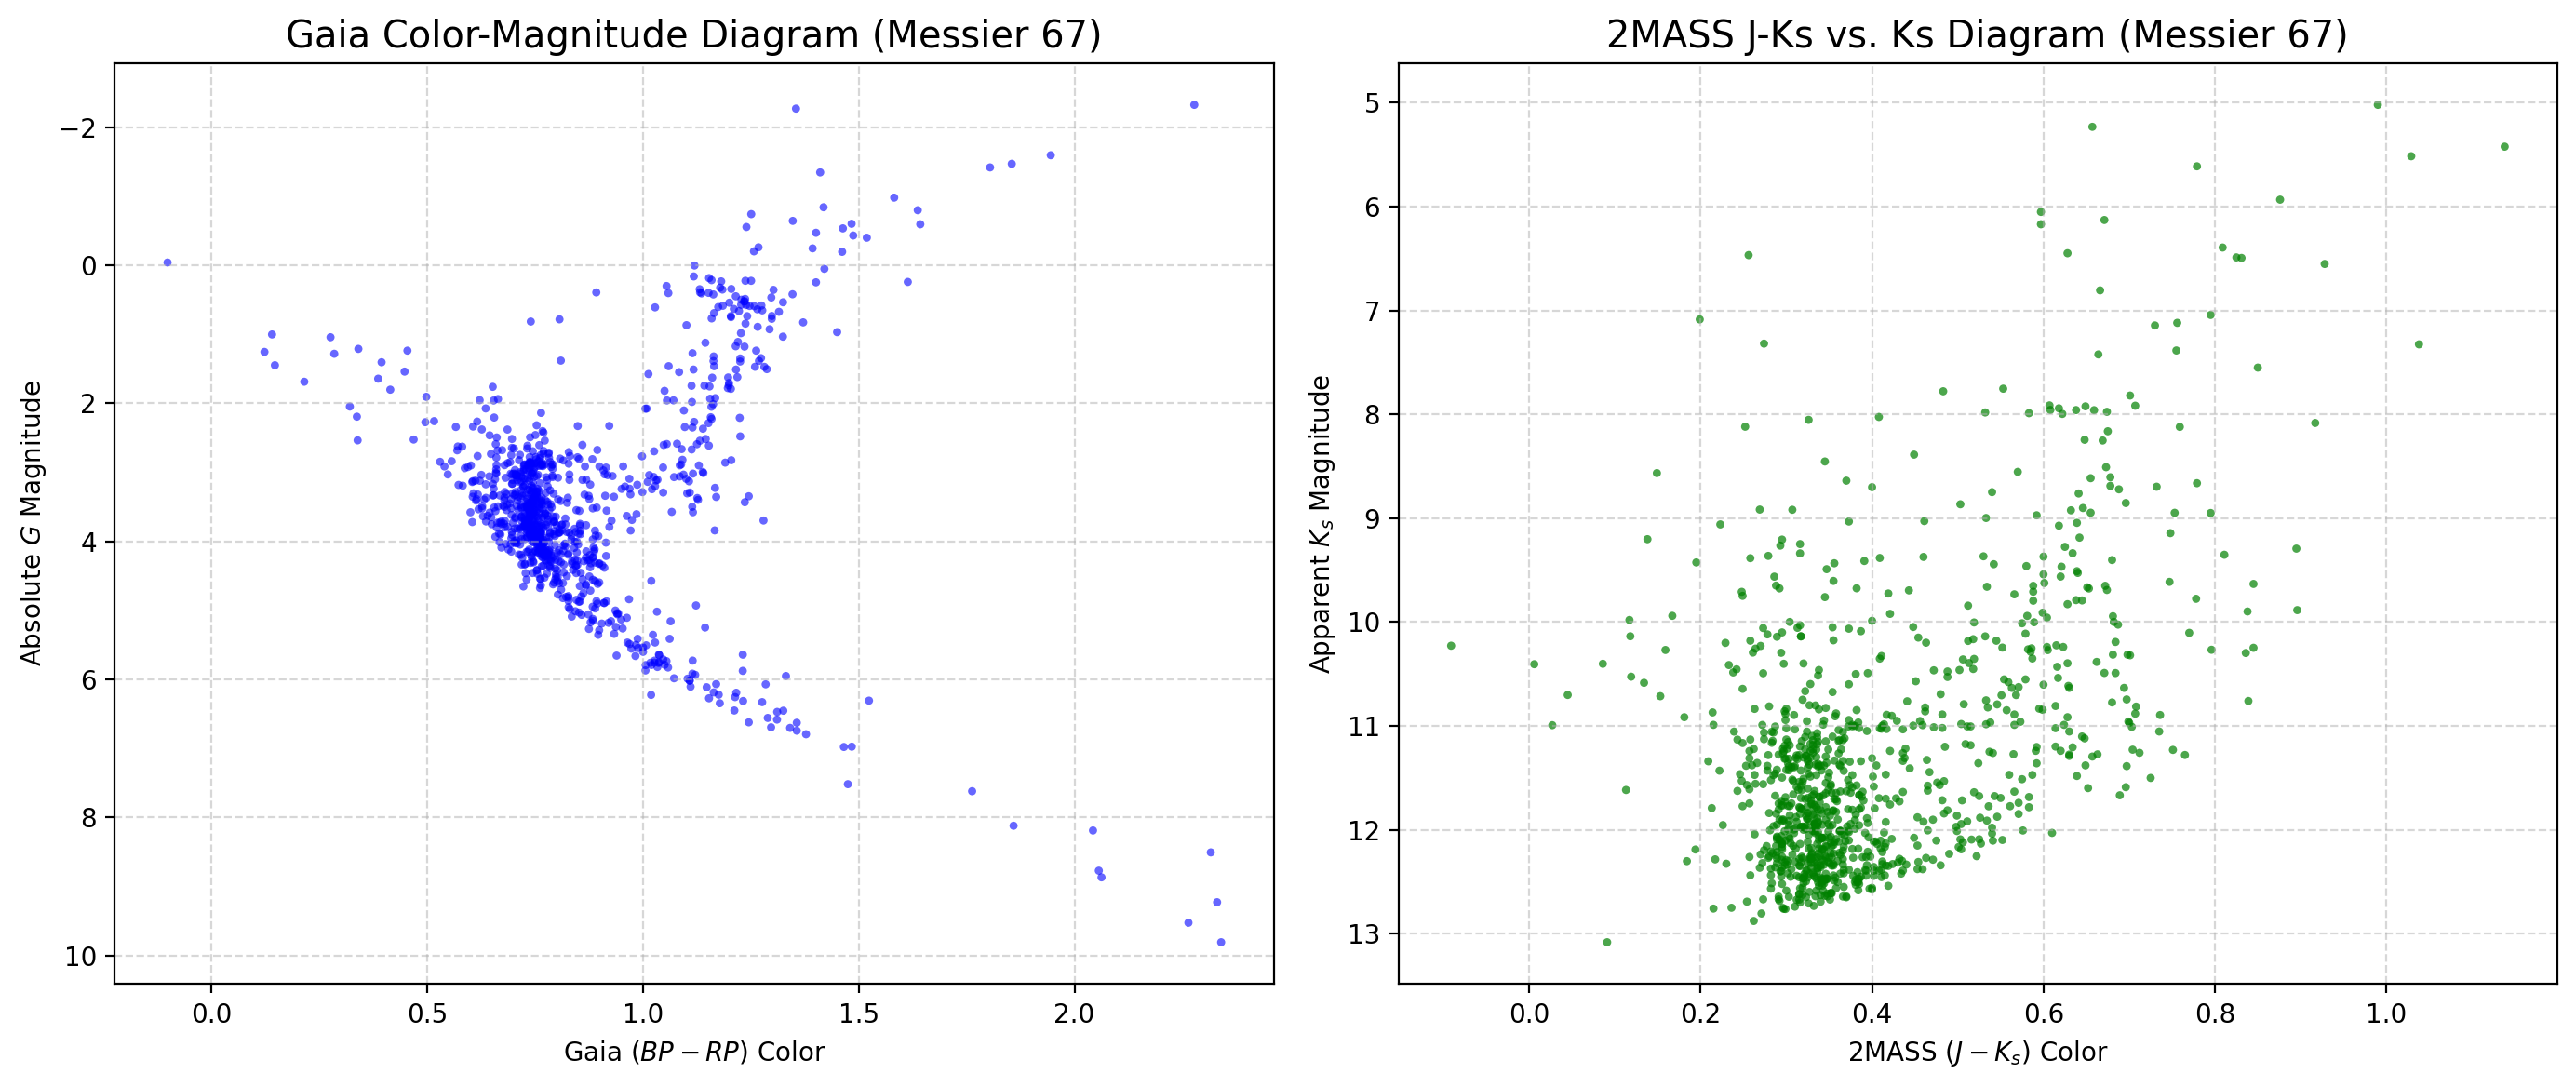

In [13]:
# Adjust layout for better spacing
# Step 5: Generate the Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=200)
plt.rcParams.update({'font.size': 12})

# Panel (a): Gaia CMD
ax1 = axes[0]
parallax = data_after_cuts['parallax'].values  # in milliarcseconds
distance_pc = 1000 / parallax
G_abs = data_after_cuts['phot_g_mean_mag'] - 5 * np.log10(distance_pc / 10)
BP_RP = data_after_cuts['bp_rp']

ax1.scatter(BP_RP, G_abs, s=10, color='blue', alpha=0.6, edgecolors='none')
ax1.invert_yaxis()
ax1.set_xlabel(r'Gaia $(BP - RP)$ Color')
ax1.set_ylabel(r'Absolute $G$ Magnitude')
ax1.set_title('Gaia Color-Magnitude Diagram (Messier 67)')
ax1.grid(True, linestyle='--', alpha=0.5)

# Panel (b): 2MASS J-Ks vs. Ks Diagram
ax2 = axes[1]
J_mag = data_after_cuts['j_m']
Ks_mag = data_after_cuts['ks_m']
J_Ks = J_mag - Ks_mag

ax2.scatter(J_Ks, Ks_mag, s=10, color='green', alpha=0.7, edgecolors='none')
ax2.invert_yaxis()
ax2.set_xlabel(r'2MASS $(J - K_s)$ Color')
ax2.set_ylabel(r'Apparent $K_s$ Magnitude')
ax2.set_title('2MASS J-Ks vs. Ks Diagram (Messier 67)')
ax2.grid(True, linestyle='--', alpha=0.5)

# Finalizing the Figure
plt.tight_layout()

# Create 'figures' directory if it doesn't exist
if not os.path.exists('figures'):
    os.makedirs('figures')

# Save the figure
plt.savefig('figures/cmds_M67.png', dpi=200)
plt.show()

Downloading the fits file 

In [14]:
url = 'https://github.com/svenbuder/astr4004_2024_week7/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits?raw=true'
response = requests.get(url)

with open('data/nihao_simulation_data.fits', 'wb') as f:
    f.write(response.content)

Now we shall ,load the fits file

In [15]:
from astropy.io import fits
import numpy as np

# Load the data
with fits.open('data/nihao_simulation_data.fits') as hdul:
    data = hdul[1].data

# Extract x, y, z, and A(O)
x = data['x']
y = data['y']
z = data['z']
A_O = data['A_O']


We need to calculate the galactrocentric radius

In [16]:
RGal = np.sqrt(x**2 + y**2 + z**2)


<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_26144/2503854321.py:34: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel('Residuals $\Delta A(O)$', fontsize=12)
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_26144/2503854321.py:16: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins='log'
  hb1 = ax1.hexbin(RGal, A_O, gridsize=100, bins='log', cmap='inferno',
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_26144/2503854321.py:30: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins='log'
  hb2 = ax2.hexbin(RGal, delta_A_O, gridsize=100, cmap='coolwarm',


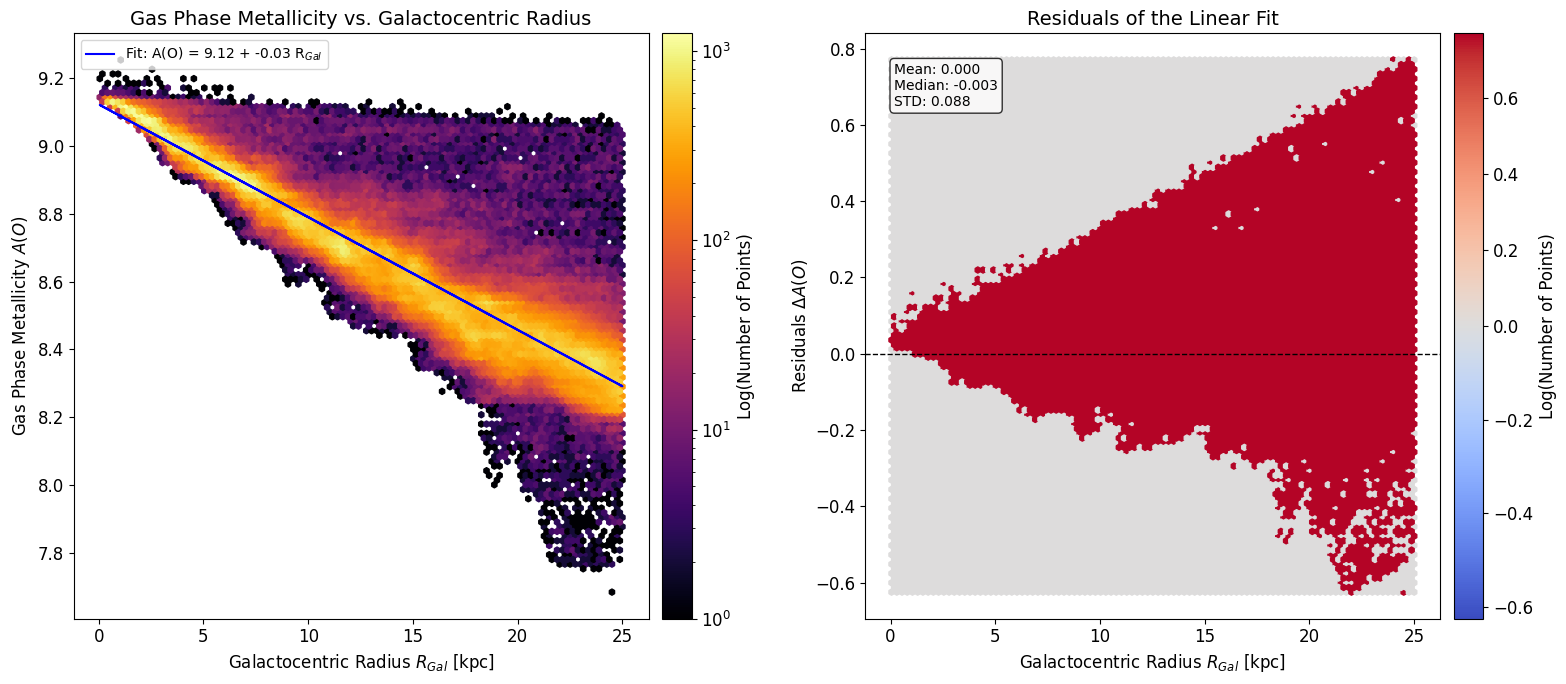

In [17]:
from scipy.stats import linregress
import matplotlib.colors as colors



slope, intercept, r_value, p_value, std_err = linregress(RGal, A_O)
A_O_fit = intercept + slope * RGal

# Calculate residuals
delta_A_O = A_O - A_O_fit

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Panel (a): A(O) vs RGal with linear fit
hb1 = ax1.hexbin(RGal, A_O, gridsize=100, bins='log', cmap='inferno',
                norm=colors.LogNorm())
ax1.plot(RGal, A_O_fit, 'b-', label=f'Fit: A(O) = {intercept:.2f} + {slope:.2f} R$_{{Gal}}$')
ax1.set_xlabel('Galactocentric Radius $R_{Gal}$ [kpc]', fontsize=12)
ax1.set_ylabel('Gas Phase Metallicity $A(O)$', fontsize=12)
ax1.set_title('Gas Phase Metallicity vs. Galactocentric Radius', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
cb1 = fig.colorbar(hb1, ax=ax1, pad=0.02)
cb1.set_label('Log(Number of Points)', fontsize=12)

# Panel (b): Residuals of the Fit
# Define a diverging norm to center the color scale at zero
divnorm = colors.TwoSlopeNorm(vmin=np.min(delta_A_O), vcenter=0, vmax=np.max(delta_A_O))

hb2 = ax2.hexbin(RGal, delta_A_O, gridsize=100, cmap='coolwarm',
                norm=divnorm, bins='log')
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.set_xlabel('Galactocentric Radius $R_{Gal}$ [kpc]', fontsize=12)
ax2.set_ylabel('Residuals $\Delta A(O)$', fontsize=12)
ax2.set_title('Residuals of the Linear Fit', fontsize=14)
cb2 = fig.colorbar(hb2, ax=ax2, pad=0.02)
cb2.set_label('Log(Number of Points)', fontsize=12)

#Add statistical summaries
mean_residual = np.mean(delta_A_O)
median_residual = np.median(delta_A_O)
std_residual = np.std(delta_A_O)
textstr = '\n'.join((
    f'Mean: {mean_residual:.3f}',
    f'Median: {median_residual:.3f}',
    f'STD: {std_residual:.3f}'))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


plt.tight_layout()
plt.savefig('figures/RGal_vs_AO_with_fit.png', dpi=300)
plt.show()

In [18]:
from scipy.optimize import curve_fit

# Define linear function
def linear_model(R, a, b):
    return a + b * R

# Fit the data
params, covariance = curve_fit(linear_model, RGal, A_O)
intercept_fit, slope_fit = params
intercept_err, slope_err = np.sqrt(np.diag(covariance))

print(f"Intercept: {intercept_fit:.4f} ± {intercept_err:.4f}")
print(f"Slope: {slope_fit:.4f} ± {slope_err:.4f}")


Intercept: 9.1223 ± 0.0003
Slope: -0.0333 ± 0.0000


In [19]:
from sklearn.metrics import mean_squared_error

sigma_estimate = np.std(delta_A_O)

# Compute chi-square
chi_square = np.sum(((A_O - A_O_fit) / sigma_estimate) ** 2)

# Degrees of freedom
degrees_of_freedom = len(A_O) - 2  # n - number of fitted parameters

# Reduced chi-square
reduced_chi_square = chi_square / degrees_of_freedom

# Compute RMSE
rmse = np.sqrt(mean_squared_error(A_O, A_O_fit))

print(f"Intercept: {intercept_fit:.4f} ± {intercept_err:.4f}")
print(f"Slope: {slope_fit:.4f} ± {slope_err:.4f}")
print(f"RMSE of the linear fit: {rmse:.4f}")
print(f"Chi-square statistic: {chi_square:.2f}")
print(f"Reduced chi-square: {reduced_chi_square:.2f}")


Intercept: 9.1223 ± 0.0003
Slope: -0.0333 ± 0.0000
RMSE of the linear fit: 0.0876
Chi-square statistic: 511520.00
Reduced chi-square: 1.00


Define Bins

In [39]:
# Define bin edges
bins = 80  # This can be adjusted as needed
x_edges = np.linspace(x.min(), x.max(), bins + 1)
y_edges = np.linspace(y.min(), y.max(), bins + 1)


<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:50: SyntaxWarning: invalid escape sequence '\D'
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_26144/3246586614.py:50: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_title('Median Residuals $\Delta A(O)$')


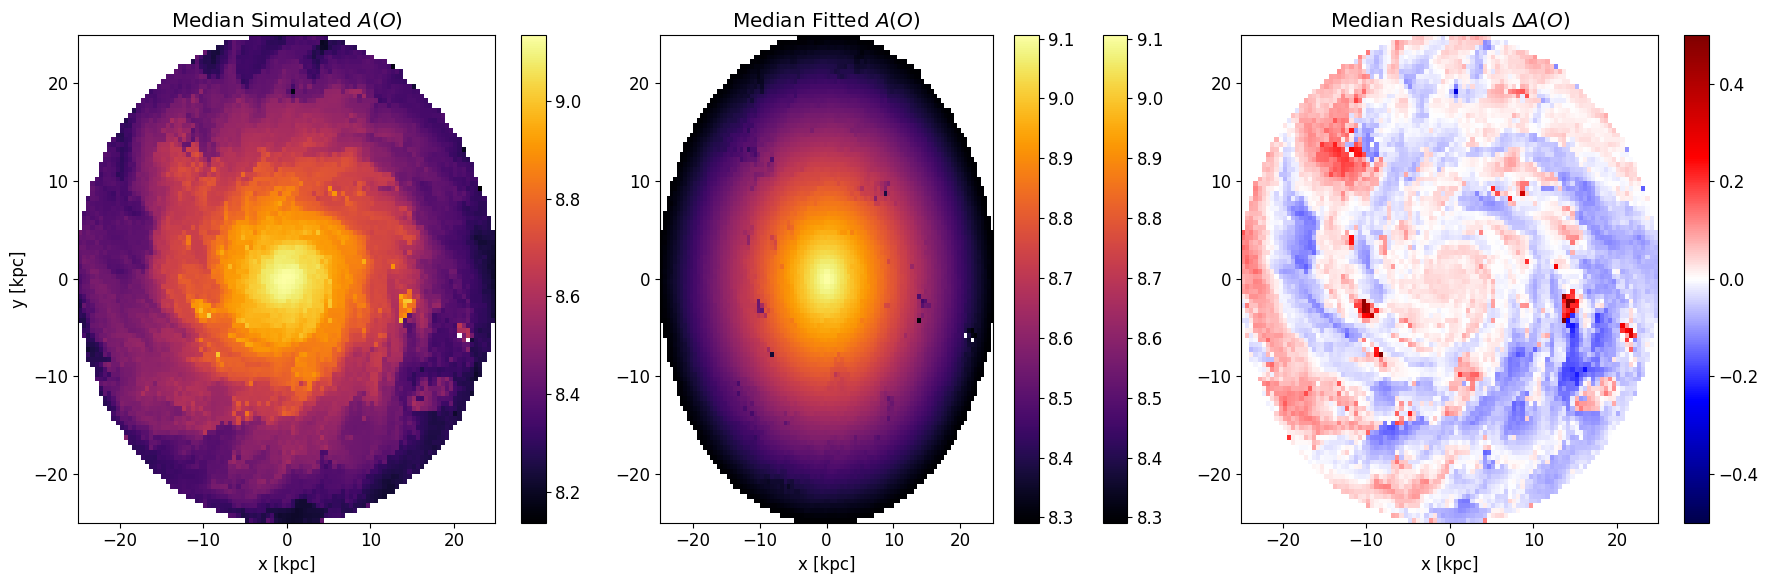

In [40]:
import scipy.stats as stats

# Compute median A(O) in each bin
median_A_O, _, _, _ = stats.binned_statistic_2d(x, y, A_O, statistic='median', bins=[x_edges, y_edges])

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
im0 = axes[0].imshow(median_A_O.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],
                     cmap='inferno', aspect='auto')
axes[0].set_title('Median Simulated $A(O)$')
axes[0].set_xlabel('x [kpc]')
axes[0].set_ylabel('y [kpc]')
fig.colorbar(im0, ax=axes[0])

# Compute fitted A(O)
A_O_fitted = intercept_fit + slope_fit * RGal

# Compute median fitted A(O) in each bin
median_A_O_fitted, _, _, _ = stats.binned_statistic_2d(x, y, A_O_fitted, statistic='median', bins=[x_edges, y_edges])

# Plot
im1 = axes[1].imshow(median_A_O_fitted.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],
                     cmap='inferno', aspect='auto')
axes[1].set_title('Median Fitted $A(O)$')
axes[1].set_xlabel('x [kpc]')
fig.colorbar(im1, ax=axes[1])

# Compute fitted A(O)
A_O_fitted = intercept_fit + slope_fit * RGal

# Compute median fitted A(O) in each bin
median_A_O_fitted, _, _, _ = stats.binned_statistic_2d(x, y, A_O_fitted, statistic='median', bins=[x_edges, y_edges])

# Plot
im1 = axes[1].imshow(median_A_O_fitted.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],
                     cmap='inferno', aspect='auto')
axes[1].set_title('Median Fitted $A(O)$')
axes[1].set_xlabel('x [kpc]')
fig.colorbar(im1, ax=axes[1])

# Compute residuals
delta_A_O = A_O - A_O_fitted

# Compute median residuals in each bin
median_delta_A_O, _, _, _ = stats.binned_statistic_2d(x, y, delta_A_O, statistic='median', bins=[x_edges, y_edges])

# Plot
im2 = axes[2].imshow(median_delta_A_O.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],
                     cmap='seismic', aspect='auto', vmin=-0.5, vmax=0.5)
axes[2].set_title('Median Residuals $\Delta A(O)$')
axes[2].set_xlabel('x [kpc]')
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig('figures/xy_plane_median_AO.png')
plt.show()
